## 목표
- 타이타닉 데이터를 생존/사망자 예측
- 머신러닝의 전체과정을 진행해보자

### 머신러닝
- 문제정의
- 데이터 수집
- 데이터 전처리
- 탐색적 데이터 분석EDA(시각화)
--------------------------------------------------------(빅데이터, 머신러닝)
- 모델 선택
- 모델 학습
- 모델 평가
- 추론(예측)

### 1. 문제정의
- 생존자/사망자를 예측
- Kaggle 경진대회에서 높은 순위를 받아보자
- 머신러닝 과정을 전체적으로 체험해보자

### 2.데이터 수집
- Kaggel 사이트에서 train.csv, test.csv 다운

In [1]:
import warnings
warnings.filterwarnings('ignore') #경고를 무시함

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('smhrd20210107/titanic_train.csv', index_col = 'PassengerId')
test = pd.read_csv('smhrd20210107/titanic_test.csv', index_col = 'PassengerId')

train.shape, test.shape

((891, 11), (418, 10))

In [4]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
y = train['Survived']
train = train.drop('Survived', axis = 1)

In [7]:
train.shape

(891, 10)

### 3~4. 데이터 전처리 및 데이터 탐색(EDA)

### 결측치(null data)확인

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


In [9]:
train.isnull().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [10]:
train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


### 결측치처리
1. 결측치 자체를 삭제

2. 결측치를 대체(평균, 중앙값, 최빈값, 예측값)

3. 결측치로 표기

Age 채우기

- 단순 기술통계차로 채우지 않고 다른 컬럼과 상관관계를 이용해 결측치를 채워보자
- Age와 다른컬럼간 상관관계를 알아보자

In [11]:
train.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000


In [12]:
pt1 = train.pivot_table(values = 'Age',
                       index= ['Pclass','Sex'],
                       aggfunc='mean') #aggfunc: 어떤 값으로 확인할지

pt1

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [13]:
#피벗 테이블에 접근하는 방법
# 피벗테이블명.loc[첫번째컬럼명,두번째컬럼명.....]
pt1.loc[3,'male']

Age    26.507589
Name: (3, male), dtype: float64

In [14]:
# Age의 결측치를 피벗테이블 참조해서 채운다.
# row: 데이터 1개
def fill_Age(row):
    # 받은 데이터의 Age가 결측치인지 확인
    if np.isnan(row['Age']):
    # 결측이 있다면 피벗테이블에서 동일한 Pclass와 Sex인 값을 가져와서 반환한다.
        return pt1.loc[row['Pclass'], row['Sex']]
    else:
    # 결측치가 없다면 Age 값을 반환
        return row['Age']

In [15]:
# apply() 함수로 결측치를 채워준다.
# train 데이터에 대해서 fill_Age() 함수로 실행한다.
# axis = 1 : 1행의 데이터를 호출한 함수로 보낸다.
# 나이는 정수형 : 함수에 넘어온 값이 실수이므로 정수형으로 변환해서 저장
train.Age = train.apply(fill_Age, axis =1).astype('int64')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 76.6+ KB


In [17]:
test.Age = test.apply(fill_Age, axis =1).astype('int64')

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


Embarked 결측치 채우기

In [19]:
# 훈련데이터에 있는 결측치 2개
# 결측치 수가 적은 범주형 데이터의 경우 : 가장 많은 수의 클래스로 채워줌
# 결측치 수가 적은 수치형 데이터의 경우 : 평균이나 중간값으로 채워줌
# Embarked -> 범주형 데이터

In [20]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [21]:
# 가장 많은 S로 채운다.
train.Embarked = train.Embarked.fillna("S")

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  891 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 76.6+ KB


In [23]:
# Pclass 와 Sex를 기준으로 Fare의 평균을 피벗 테이블로 생성
pt2 = train.pivot_table(values = 'Fare',
                       index= ['Pclass','Sex'],
                       aggfunc='mean') #aggfunc: 어떤 값으로 확인할지

pt2

Fare
Pclass Sex               
1      female  106.125798
       male     67.226127
2      female   21.970121
       male     19.741782
3      female   16.118810
       male     12.661633

In [24]:
# 결측치가 있는 Fare 데이터의 값을 채우는 함수
def fill_Fare(row):
    if np.isnan(row['Fare']):
        return pt2.loc[row['Pclass'], row['Sex']]
    else:
        return row['Fare']

In [25]:
# Fare 컬럼중에서 결츨치가 있는 데이터만 출력
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,NaN,NaN,S


In [26]:
# Fare 데이터의 결측치를 함수로 호출하여 채움
test.Fare = test.apply(fill_Fare, axis =1).astype('float64')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [27]:
test[test['Name'] == 'Storey, Mr. Thomas']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,12.661633,NaN,S


In [28]:
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [29]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
F33            3
C22 C26        3
              ..
D11            1
B50            1
B79            1
E36            1
C99            1
Name: Cabin, Length: 147, dtype: int64

In [30]:
# 어느 클래스에 넣을지 판단하기 힘들 다수의 결측치는 임의의 값으로 치환
# 객실번호 앞 알파벳에 속하지 않는 알파벳으로 결측치를 채움(M으로 채움)
# Deck 컬럼을 추가해서 결측치를 채움
train['Deck'] = train.Cabin.fillna('M')
test['Deck'] = test.Cabin.fillna('M')

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 83.5+ KB


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Deck      418 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 39.2+ KB


In [33]:
train.Deck.value_counts()

M              687
C23 C25 C27      4
G6               4
B96 B98          4
E101             3
              ... 
C95              1
D15              1
A19              1
C70              1
C99              1
Name: Deck, Length: 148, dtype: int64

In [34]:
# 객실번호에서 첫번째 영문자만 잘라서 저장
train.Deck = train.Deck.str[0]
test.Deck = test.Deck.str[0]

train.Deck.value_counts()

M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

In [35]:
test.Deck.value_counts()

M    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64

In [36]:
# 필요가 없어진 Cabin 컬럼은 삭제
train.drop('Cabin', axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
 9   Deck      891 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 76.6+ KB


In [37]:
del test['Cabin']

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Embarked  418 non-null    object 
 9   Deck      418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


## 데이터 전처리 및 시각화

Deck 과 Survived간의 관계
- 객실별 생존사망 수를 계수

In [38]:
train = pd.concat([train, y], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
 9   Deck      891 non-null    object 
 10  Survived  891 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


<AxesSubplot:xlabel='Deck', ylabel='count'>

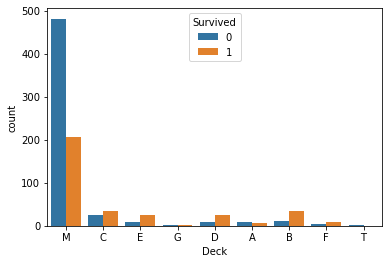

In [39]:
import seaborn as sns

sns.countplot(data = train, x= 'Deck', hue='Survived')

Pclass별 생존,사망수를 계수

<AxesSubplot:xlabel='Pclass', ylabel='count'>

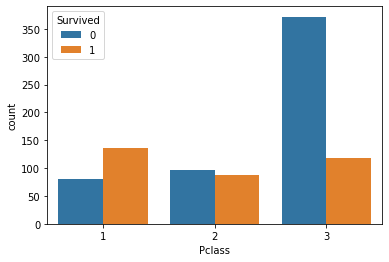

In [40]:
sns.countplot(data = train, x= 'Pclass', hue='Survived')

<AxesSubplot:xlabel='Deck', ylabel='count'>

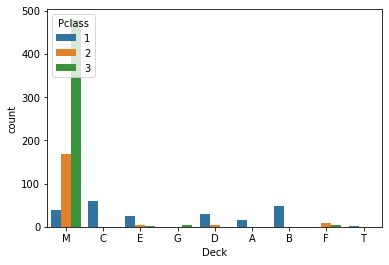

In [41]:
# Deck 기분으로 Pcalss의 수를 카운트
sns.countplot(data = train, x= 'Deck', hue='Pclass')

(문제) Sex, Embarked에 대해서도 Survived를 분석

<AxesSubplot:xlabel='Sex', ylabel='count'>

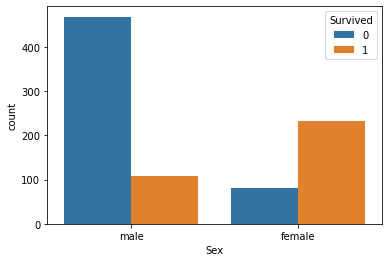

In [42]:
sns.countplot(data = train, x= 'Sex', hue='Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

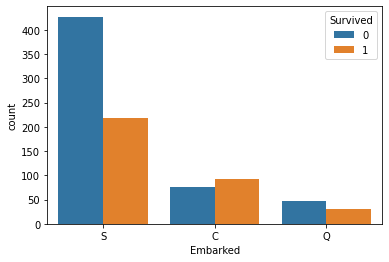

In [43]:
sns.countplot(data = train, x= 'Embarked', hue='Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

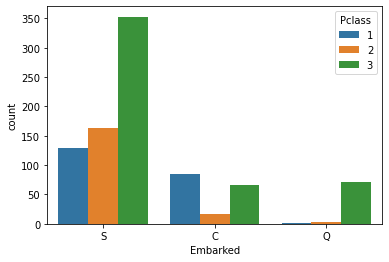

In [44]:
sns.countplot(data = train, x= 'Embarked', hue='Pclass')

수치형 데이터의 시각화 - KDE, line, violinplot 등

- Age 시각화

- violinplot = boxplot과 KDE plot을 합쳐 놓은 것

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

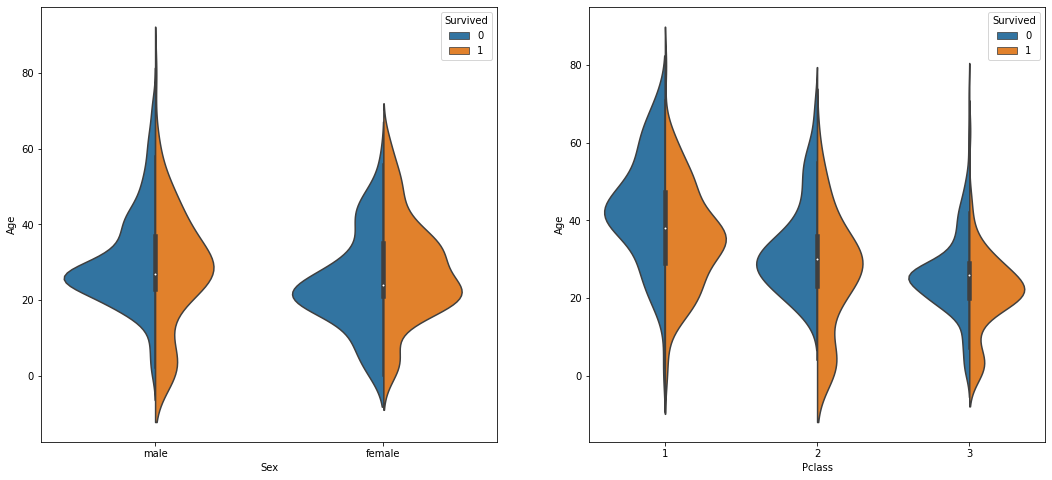

In [45]:
f, ax = plt.subplots(1,2,figsize= (18,8))
sns.violinplot(data = train, x = 'Sex', y = 'Age', hue= 'Survived', split = True, ax = ax[0])
sns.violinplot(data = train, x = 'Pclass', y = 'Age', hue= 'Survived', split = True, ax = ax[1])

#### Age를 범주형 데이터로 변경 (수치 -> 범주 : binning)

- 나이가 0-80세로 연속된 숫자로 되어 있어 학습 정확도가 낮아질 수 있어서

    -0-9 (0), 10-19 (1), 20-29 (2), 30-39 (3), 40-49 (4), 50-59 (5), 60-69 (6), 70-79 (7),

In [46]:
# def Age_cat(row) :
#     if row < 10:
#         return 0
#     elif row < 20:
#         return 1
#     elif row < 30:
#         return 2
#     elif row < 40:
#         return 3
#     elif row < 50:
#         return 4
#     elif row < 60:
#         return 5
#     elif row < 70:
#         return 6
#     else:
#         return 7
    

# train['Age_cut'] = train.Age.apply(Age_cat).astype('int64')
train['Age_cut']=pd.cut(train.Age, bins=[-1,10,20,30,40,50,60,70,90],labels=['0','1','2','3','4','5','6','7'])

In [47]:
train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Survived,Age_cut
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,M,0,2
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,1,3
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,M,1,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,C,1,3
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,M,0,3


In [48]:
del train['Age']
train.head()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Deck,Survived,Age_cut
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,M,0,2
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,C,1,3
3,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,M,1,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,C,1,3
5,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,M,0,3


train["Age_cut"]=train["Age"]//10
train["Age_cut"][train["Age"]>=80]=7


train['Age_cut']=pd.cut(train.Age, bins=[0,10,20,30,40,50,60,70,90],labels=['0','1','2','3','4','5','6','7'])

In [49]:
test['Age_cut'] = pd.cut(test.Age, bins = [-1,10,20,30,40,50,60,70,90],
                     labels = ['0','1','2','3','4','5','6','7'])
del test['Age']

test.head()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Deck,Age_cut
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,0,0,330911,7.8292,Q,M,3
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,7.0000,S,M,4
894,2,"Myles, Mr. Thomas Francis",male,0,0,240276,9.6875,Q,M,6
895,3,"Wirz, Mr. Albert",male,0,0,315154,8.6625,S,M,2
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,3101298,12.2875,S,M,2


In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    418 non-null    int64   
 1   Name      418 non-null    object  
 2   Sex       418 non-null    object  
 3   SibSp     418 non-null    int64   
 4   Parch     418 non-null    int64   
 5   Ticket    418 non-null    object  
 6   Fare      418 non-null    float64 
 7   Embarked  418 non-null    object  
 8   Deck      418 non-null    object  
 9   Age_cut   418 non-null    category
dtypes: category(1), float64(1), int64(3), object(5)
memory usage: 33.4+ KB


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    int64   
 1   Name      891 non-null    object  
 2   Sex       891 non-null    object  
 3   SibSp     891 non-null    int64   
 4   Parch     891 non-null    int64   
 5   Ticket    891 non-null    object  
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    object  
 8   Deck      891 non-null    object  
 9   Survived  891 non-null    int64   
 10  Age_cut   891 non-null    category
dtypes: category(1), float64(1), int64(4), object(5)
memory usage: 117.8+ KB


In [52]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:xlabel='Sex', ylabel='Fare'>

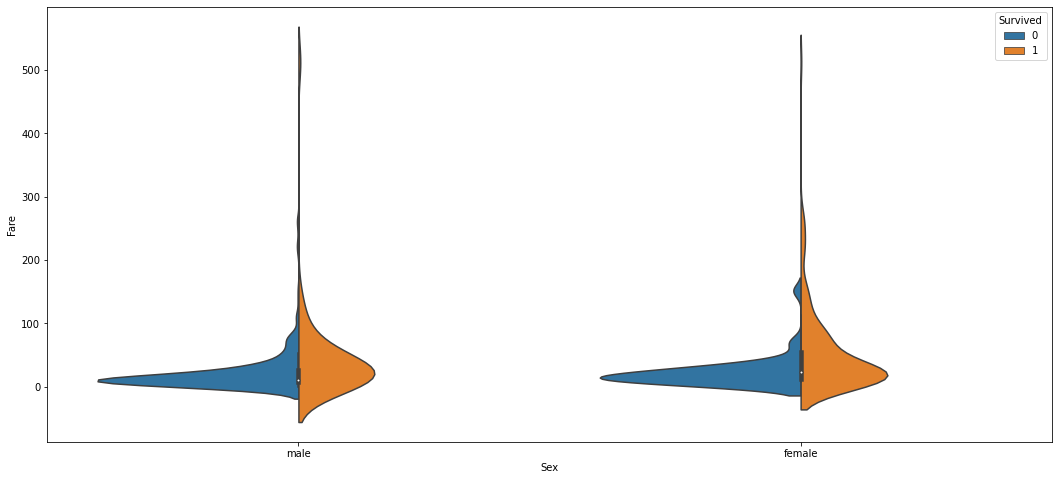

In [53]:
plt.figure(figsize = (18,8))
sns.violinplot(data = train, x = 'Sex', y= 'Fare', hue = 'Survived', split = True)

## Fare데이터 분포 확인

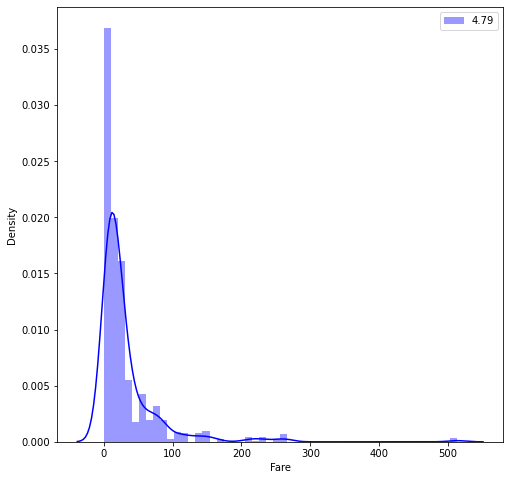

In [54]:
plt.figure(figsize=(8,8))
g = sns.distplot(train.Fare, color = 'b', label= '{:.2f}'.format(train.Fare.skew()))
g.legend()

In [55]:
train['Fare'] = np.log(train['Fare']+1)
test['Fare'] = np.log(test['Fare']+1)

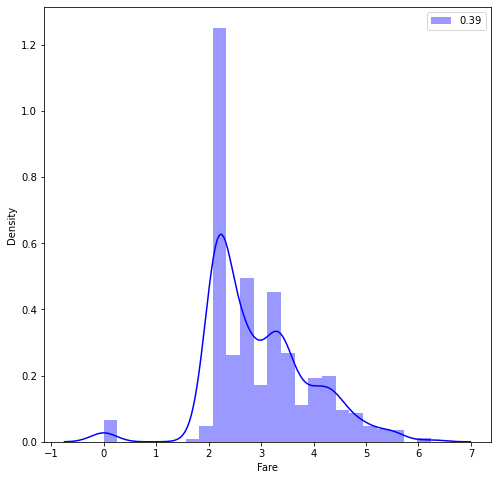

In [56]:
plt.figure(figsize=(8,8))
g = sns.distplot(train.Fare, color = 'b', label= '{:.2f}'.format(train.Fare.skew()))
g.legend()

### 로그를 취해줘서 비대칭성이 많이 사라짐(정규분포에 가까워짐)

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    int64   
 1   Name      891 non-null    object  
 2   Sex       891 non-null    object  
 3   SibSp     891 non-null    int64   
 4   Parch     891 non-null    int64   
 5   Ticket    891 non-null    object  
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    object  
 8   Deck      891 non-null    object  
 9   Survived  891 non-null    int64   
 10  Age_cut   891 non-null    category
dtypes: category(1), float64(1), int64(4), object(5)
memory usage: 117.8+ KB


### Parch, Sibsp - 부모자식, 형제배우자
- 특성공학: 기존의 특성을 이용하여 좀 더 유용한 특성을 만들어보자
- Family_size = Parch + Sibsp

In [58]:
train['Family_size'] = train['Parch'] + train['SibSp'] +1 
test['Family_size'] = test['Parch']+ test['SibSp']+1

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       891 non-null    int64   
 1   Name         891 non-null    object  
 2   Sex          891 non-null    object  
 3   SibSp        891 non-null    int64   
 4   Parch        891 non-null    int64   
 5   Ticket       891 non-null    object  
 6   Fare         891 non-null    float64 
 7   Embarked     891 non-null    object  
 8   Deck         891 non-null    object  
 9   Survived     891 non-null    int64   
 10  Age_cut      891 non-null    category
 11  Family_size  891 non-null    int64   
dtypes: category(1), float64(1), int64(5), object(5)
memory usage: 124.8+ KB


In [60]:
train.drop('Parch', axis=1, inplace=True)
test.drop('Parch', axis=1, inplace=True)
train.drop('SibSp', axis=1, inplace=True)
test.drop('SibSp', axis=1, inplace=True)

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       891 non-null    int64   
 1   Name         891 non-null    object  
 2   Sex          891 non-null    object  
 3   Ticket       891 non-null    object  
 4   Fare         891 non-null    float64 
 5   Embarked     891 non-null    object  
 6   Deck         891 non-null    object  
 7   Survived     891 non-null    int64   
 8   Age_cut      891 non-null    category
 9   Family_size  891 non-null    int64   
dtypes: category(1), float64(1), int64(3), object(5)
memory usage: 110.9+ KB


<AxesSubplot:xlabel='Family_size', ylabel='count'>

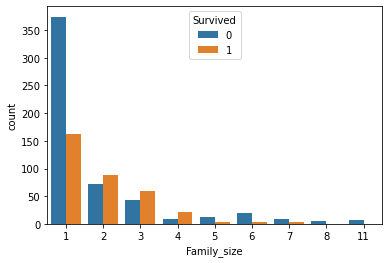

In [62]:
sns.countplot(data = train, x = 'Family_size', hue = 'Survived')

- 1: 죽은 사람
- 2~4 : 산사람
- 5명 이상일 경우 죽은사람

### bining 수치형 -> 카테고리 형
- 가족사이즈 1: 'Alone'
- 가족사이즈 2~4: 'Small'
- 가족사이즈 5이상: 'Large'

In [63]:
test['Family_size'].unique()

array([ 1,  2,  3,  5,  4,  6,  8,  7, 11], dtype=int64)

In [64]:
bins = [0,1,4,11]
labels = ['Alone', 'Small', 'Large']
train['Family_Group'] = pd.cut(train['Family_size'], bins=bins, labels=labels)
test['Family_Group'] = pd.cut(test['Family_size'], bins=bins, labels=labels)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        891 non-null    int64   
 1   Name          891 non-null    object  
 2   Sex           891 non-null    object  
 3   Ticket        891 non-null    object  
 4   Fare          891 non-null    float64 
 5   Embarked      891 non-null    object  
 6   Deck          891 non-null    object  
 7   Survived      891 non-null    int64   
 8   Age_cut       891 non-null    category
 9   Family_size   891 non-null    int64   
 10  Family_Group  891 non-null    category
dtypes: category(2), float64(1), int64(3), object(5)
memory usage: 111.8+ KB


<AxesSubplot:xlabel='Family_Group', ylabel='count'>

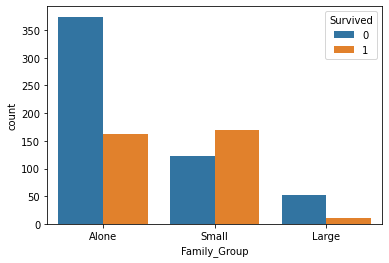

In [66]:
sns.countplot(data= train, x ='Family_Group', hue = 'Survived')

In [67]:
del train['Family_size']
del test['Family_size']

### Text 데이터 다루기

### Name 시각화

In [68]:
train['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [69]:
def split_title(row):
    # , 로 잘라낸 문자열리스트의 2번째 값
    # strip(): 해당 문아열내에서 공백문자 제거
    return row.split(',')[1].split('.')[0].strip()

In [70]:
train['initial'] = train['Name'].apply(split_title)
train['initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [71]:
test['initial'] = test['Name'].apply(split_title)
test['initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [72]:
del train['Name']
del test['Name']

<AxesSubplot:xlabel='initial', ylabel='count'>

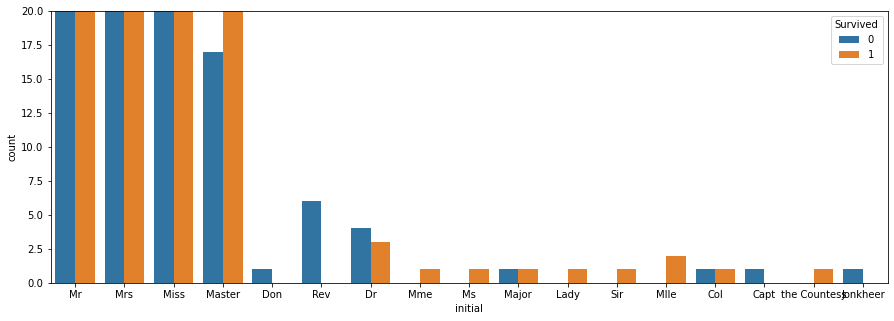

In [73]:
plt.figure(figsize=(15,5))
plt.ylim(0,20)
sns.countplot(data = train, x = 'initial', hue = 'Survived')

In [74]:
train['initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [75]:
# set자료형 - 집합
set(test['initial'].unique()) - set(train['initial'].unique())

{'Dona'}

In [76]:
# Dr 중 여성은 49세의 여성이어서 결혼을 했을 것으로 판단하여 Mrs로 변경
train['initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                         ['Miss','Miss','Miss','Mrs','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

test['initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mrs','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [77]:
train['initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

## 티켓

In [78]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    object  
 2   Fare          418 non-null    float64 
 3   Embarked      418 non-null    object  
 4   Deck          418 non-null    object  
 5   Age_cut       418 non-null    category
 6   Family_Group  418 non-null    category
 7   initial       418 non-null    object  
dtypes: category(2), float64(1), int64(1), object(4)
memory usage: 24.2+ KB


In [80]:
train.head()

,Pclass,Sex,Fare,Embarked,Deck,Survived,Age_cut,Family_Group,initial
PassengerId,,,,,,,,,
1,3,male,2.110213,S,M,0,2,Small,Mr
2,1,female,4.280593,C,C,1,3,Small,Mrs
3,3,female,2.188856,S,M,1,2,Alone,Miss
4,1,female,3.990834,S,C,1,3,Small,Mrs
5,3,male,2.202765,S,M,0,3,Alone,Mr


In [81]:
train['Family_Group'] = train['Family_Group'].astype('object')
train['Age_cut'] = train['Age_cut'].astype('object')
test['Family_Group'] = test['Family_Group'].astype('object')
test['Age_cut'] = test['Age_cut'].astype('object')

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        891 non-null    int64  
 1   Sex           891 non-null    object 
 2   Fare          891 non-null    float64
 3   Embarked      891 non-null    object 
 4   Deck          891 non-null    object 
 5   Survived      891 non-null    int64  
 6   Age_cut       891 non-null    object 
 7   Family_Group  891 non-null    object 
 8   initial       891 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 109.6+ KB


In [83]:
# 연관관계 분석을 위해 문자를 수치로 변경
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test['Embarked'] = test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
train['Deck'] = train['Deck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'M': 7, 'T': 8})
test['Deck'] = test['Deck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'M': 7, 'T': 8})
train['Family_Group'] = train['Family_Group'].map({'Alone': 0, 'Small': 1, 'Large': 2})
test['Family_Group'] = test['Family_Group'].map({'Alone': 0, 'Small': 1, 'Large': 2})
train['initial'] = train['initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
test['initial'] = test['initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

train['Age_cut'] = train['Age_cut'].map({'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7})
test['Age_cut'] = test['Age_cut'].map({'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7})

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        891 non-null    int64  
 1   Sex           891 non-null    int64  
 2   Fare          891 non-null    float64
 3   Embarked      891 non-null    int64  
 4   Deck          891 non-null    int64  
 5   Survived      891 non-null    int64  
 6   Age_cut       891 non-null    int64  
 7   Family_Group  891 non-null    int64  
 8   initial       891 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 109.6 KB


In [85]:
train.corr()

,Pclass,Sex,Fare,Embarked,Deck,Survived,Age_cut,Family_Group,initial
Pclass,1.000000,-0.131900,-0.661022,0.162098,0.742093,-0.338481,-0.407116,-0.043973,-0.144695
Sex,-0.131900,1.000000,0.263276,-0.108262,-0.118635,0.543351,-0.090930,0.280570,-0.055823
Fare,-0.661022,0.263276,1.000000,-0.202444,-0.574672,0.329862,0.154104,0.466154,-0.014682
Embarked,0.162098,-0.108262,-0.202444,1.000000,0.199444,-0.167675,-0.011371,-0.004951,0.022995
Deck,0.742093,-0.118635,-0.574672,0.199444,1.000000,-0.295113,-0.290680,-0.079182,-0.055267
Survived,-0.338481,0.543351,0.329862,-0.167675,-0.295113,1.000000,-0.047698,0.108631,-0.083808
Age_cut,-0.407116,-0.090930,0.154104,-0.011371,-0.290680,-0.047698,1.000000,-0.216699,0.454734
Family_Group,-0.043973,0.280570,0.466154,-0.004951,-0.079182,0.108631,-0.216699,1.000000,-0.109933
initial,-0.144695,-0.055823,-0.014682,0.022995,-0.055267,-0.083808,0.454734,-0.109933,1.000000


<AxesSubplot:>

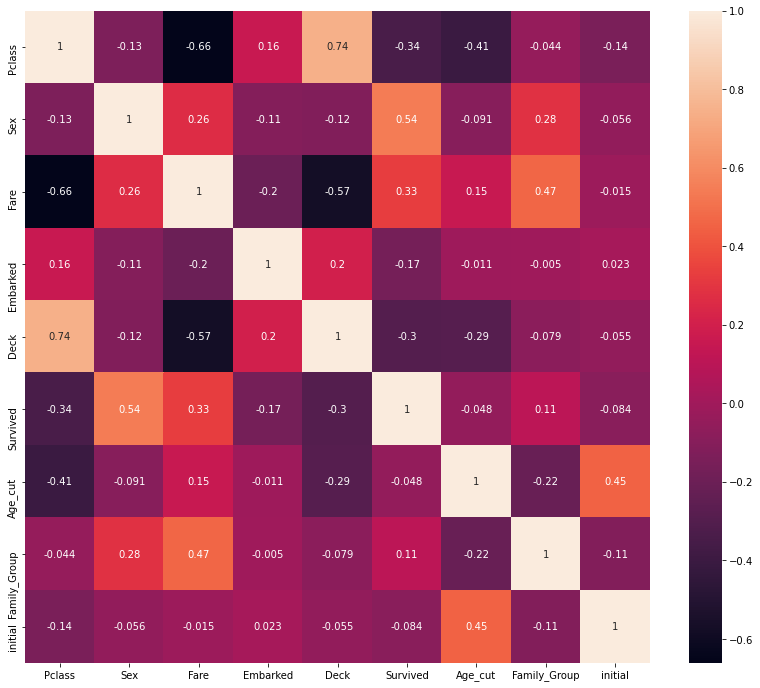

In [86]:
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(), annot=True)

In [87]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Sex           418 non-null    int64  
 2   Fare          418 non-null    float64
 3   Embarked      418 non-null    int64  
 4   Deck          418 non-null    int64  
 5   Age_cut       418 non-null    int64  
 6   Family_Group  418 non-null    int64  
 7   initial       418 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 29.4 KB


## 특성선택
- 특성, 라벨로 분리

In [88]:
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test

In [89]:
X_train.columns

Index(['Pclass', 'Sex', 'Fare', 'Embarked', 'Deck', 'Age_cut', 'Family_Group',
       'initial'],
      dtype='object')

In [90]:
# 원핫 인코딩할 컬럼 목록
# 카테고리가 두개뿐인 컬럼은 원핫인코딩의 의미가 크게 없음
# Fare는 연속형 데이터이므로 제외
cat_feature = ['Pclass', 'Embarked', 'Deck', 'Age_cut', 'Family_Group', 'initial']

In [91]:
for col_name in cat_feature:
    dummy = pd.get_dummies(train[col_name], prefix= col_name)
    X_train = pd.concat([X_train, dummy], axis = 1)
    X_train.drop(col_name, axis = 1, inplace=True)

In [92]:
X_train

,Sex,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_0,Embarked_1,Embarked_2,Deck_0,Deck_1,...,Age_cut_6,Age_cut_7,Family_Group_0,Family_Group_1,Family_Group_2,initial_0,initial_1,initial_2,initial_3,initial_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,2.110213,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,4.280593,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,2.188856,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
4,1,3.990834,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0,2.202765,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2.639057,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
888,1,3.433987,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
889,1,3.196630,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [93]:
for col_name in cat_feature:
    dummy = pd.get_dummies(test[col_name], prefix= col_name)
    X_test = pd.concat([X_test, dummy], axis = 1)
    X_test.drop(col_name, axis = 1, inplace=True)

In [94]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             418 non-null    int64  
 1   Fare            418 non-null    float64
 2   Pclass_1        418 non-null    uint8  
 3   Pclass_2        418 non-null    uint8  
 4   Pclass_3        418 non-null    uint8  
 5   Embarked_0      418 non-null    uint8  
 6   Embarked_1      418 non-null    uint8  
 7   Embarked_2      418 non-null    uint8  
 8   Deck_0          418 non-null    uint8  
 9   Deck_1          418 non-null    uint8  
 10  Deck_2          418 non-null    uint8  
 11  Deck_3          418 non-null    uint8  
 12  Deck_4          418 non-null    uint8  
 13  Deck_5          418 non-null    uint8  
 14  Deck_6          418 non-null    uint8  
 15  Deck_7          418 non-null    uint8  
 16  Age_cut_0       418 non-null    uint8  
 17  Age_cut_1       418 non-null    

In [95]:
# X_test보다 X_train의 컬럼수가 하나 더 많은데 어떤 컬럼인지 알아보자
set(X_train.columns) - set(X_test.columns)

{'Deck_8'}

In [96]:
#컬럼을 추가하고 초기화
X_test['Deck_8'] = 0

In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             891 non-null    int64  
 1   Fare            891 non-null    float64
 2   Pclass_1        891 non-null    uint8  
 3   Pclass_2        891 non-null    uint8  
 4   Pclass_3        891 non-null    uint8  
 5   Embarked_0      891 non-null    uint8  
 6   Embarked_1      891 non-null    uint8  
 7   Embarked_2      891 non-null    uint8  
 8   Deck_0          891 non-null    uint8  
 9   Deck_1          891 non-null    uint8  
 10  Deck_2          891 non-null    uint8  
 11  Deck_3          891 non-null    uint8  
 12  Deck_4          891 non-null    uint8  
 13  Deck_5          891 non-null    uint8  
 14  Deck_6          891 non-null    uint8  
 15  Deck_7          891 non-null    uint8  
 16  Deck_8          891 non-null    uint8  
 17  Age_cut_0       891 non-null    uin

In [98]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             418 non-null    int64  
 1   Fare            418 non-null    float64
 2   Pclass_1        418 non-null    uint8  
 3   Pclass_2        418 non-null    uint8  
 4   Pclass_3        418 non-null    uint8  
 5   Embarked_0      418 non-null    uint8  
 6   Embarked_1      418 non-null    uint8  
 7   Embarked_2      418 non-null    uint8  
 8   Deck_0          418 non-null    uint8  
 9   Deck_1          418 non-null    uint8  
 10  Deck_2          418 non-null    uint8  
 11  Deck_3          418 non-null    uint8  
 12  Deck_4          418 non-null    uint8  
 13  Deck_5          418 non-null    uint8  
 14  Deck_6          418 non-null    uint8  
 15  Deck_7          418 non-null    uint8  
 16  Age_cut_0       418 non-null    uint8  
 17  Age_cut_1       418 non-null    

In [99]:
X_test = pd.DataFrame(X_test, columns=X_train.columns)

## 모델 선택 및 학습

In [100]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 3)

In [101]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [102]:
knn_model.score(X_train, y_train)

0.8731762065095399

In [103]:
pred = knn_model.predict(X_test)

In [104]:
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [105]:
csv = pd.read_csv('smhrd20210107/gender_submission.csv')

In [106]:
csv['Survived'] = pred

In [107]:
csv

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [108]:
csv.to_csv('sub1.csv', index = False) # 데이터프레임을 csv파일로 저장

In [109]:
from sklearn.model_selection import cross_val_score

In [110]:
#cross_val_score(모델, 특성데이터,cv = 5)
# cv는 몇번에 나누어 검증을 할지
result = cross_val_score(knn_model, X_train, y_train, cv=5)
result

array([0.78212291, 0.79775281, 0.84831461, 0.80337079, 0.80337079])

In [111]:
result.mean()

0.8069863787583955

In [112]:
X_train.Fare.max(), X_train.Fare.min()

(6.240917354759096, 0.0)

In [113]:
X_train.Sex.unique()

array([0, 1], dtype=int64)

In [114]:
from sklearn.preprocessing import StandardScaler

In [115]:
ss = StandardScaler()

In [116]:
ss.fit(X_train)

StandardScaler()

In [117]:
X_train_ss = pd.DataFrame(ss.transform(X_train))
X_train_ss

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.737695,-0.879741,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,-1.231645,1.432260,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
1,1.355574,1.361220,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.623803,-0.130856,-0.235981,...,-0.143592,-0.067153,-1.231645,1.432260,-0.273476,-0.216803,-0.513644,-1.189384,2.376816,-0.101015
2,1.355574,-0.798540,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,1.946875,-1.189384,-0.420731,-0.101015
3,1.355574,1.062038,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,-1.231645,1.432260,-0.273476,-0.216803,-0.513644,-1.189384,2.376816,-0.101015
4,-0.737695,-0.784179,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.737695,-0.333698,-0.565685,1.960202,-1.107926,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,-1.189384,-0.420731,9.899495
887,1.355574,0.487082,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.615838,-0.130856,4.237623,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,1.946875,-1.189384,-0.420731,-0.101015
888,1.355574,0.242007,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,-1.231645,1.432260,-0.273476,-0.216803,1.946875,-1.189384,-0.420731,-0.101015
889,-0.737695,0.487082,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.623803,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015


In [118]:
X_test_ss = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
X_test_ss

,Sex,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_0,Embarked_1,Embarked_2,Deck_0,Deck_1,...,Age_cut_6,Age_cut_7,Family_Group_0,Family_Group_1,Family_Group_2,initial_0,initial_1,initial_2,initial_3,initial_4
0,-0.737695,-0.809683,-0.565685,-0.510152,0.902587,-0.482043,3.251373,-1.623803,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
1,1.355574,-0.911513,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,-1.231645,1.432260,-0.273476,-0.216803,-0.513644,-1.189384,2.376816,-0.101015
2,-0.737695,-0.612461,-0.565685,1.960202,-1.107926,-0.482043,3.251373,-1.623803,-0.130856,-0.235981,...,6.964194,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
3,-0.737695,-0.716562,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
4,1.355574,-0.387631,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,-1.231645,1.432260,-0.273476,-0.216803,-0.513644,-1.189384,2.376816,-0.101015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.737695,-0.784179,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
414,1.355574,1.793823,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.623803,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
415,-0.737695,-0.879741,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015
416,-0.737695,-0.784179,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.130856,-0.235981,...,-0.143592,-0.067153,0.811922,-0.698197,-0.273476,-0.216803,-0.513644,0.840771,-0.420731,-0.101015


In [119]:
#fit_transform : 훈련가 변환을 동시에 진행
# test -> fit_trasform 사용시 test에 맞춰서 훈련이 진행후 변환되기 때문에 test에는 사용 x
ss.fit_transform(X_train.loc[:,'Fare':'Fare'])

array([[-0.87974057],
       [ 1.36121993],
       [-0.79853997],
       [ 1.06203806],
       [-0.78417924],
       [-0.7386163 ],
       [ 1.03814556],
       [ 0.13649914],
       [-0.48145578],
       [ 0.48943791],
       [-0.091565  ],
       [ 0.36526094],
       [-0.78417924],
       [ 0.52869893],
       [-0.80676338],
       [-0.13322852],
       [ 0.45751954],
       [-0.33369847],
       [-0.01838584],
       [-0.88287417],
       [ 0.34443948],
       [-0.33369847],
       [-0.78655506],
       [ 0.65571883],
       [ 0.13649914],
       [ 0.53229169],
       [-0.88287417],
       [ 2.69870078],
       [-0.80385215],
       [-0.80192362],
       [ 0.40823345],
       [ 2.09779492],
       [-0.81898658],
       [-0.53680577],
       [ 1.50608578],
       [ 1.04082775],
       [-0.88234706],
       [-0.78417924],
       [-0.01838584],
       [-0.47227212],
       [-0.63319725],
       [ 0.13298517],
       [-0.80192362],
       [ 0.81478225],
       [-0.80385215],
       [-0

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
rf = RandomForestClassifier(n_estimators=11, max_features=5, random_state=77)

In [130]:
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9438832772166106

In [131]:
result = cross_val_score(rf, X_train, y_train, cv=5)
result.mean() #과대적합 조금 해소

0.7912372104701526

In [132]:
!pip install xgboost

In [133]:
!pip install lightgbm

In [134]:
from xgboost import XGBClassifier

In [139]:
xgb = XGBClassifier(n_estimators = 50, max_depth = 5, learning_rate = 0.1)
# 파라미터를 설정해주지 않으면 모델 내에  설정된 기본값들이 들어가게 됨

In [143]:
#early_stopping_rounds = 10, validation score 10회동안 나아지지 않으면 종료
xgb.fit(X_train, y_train)

[17:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
result = cross_val_score(xgb, X_train, y_train, cv = 5)
result.mean()

[17:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.827154604230745

In [145]:
from lightgbm import LGBMClassifier

In [150]:
lgbm = LGBMClassifier(max_depth=5, n_estimators=50, learning_rate=0.1)

In [151]:
lgbm.fit(X_train,y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(max_depth=5, n_estimators=50)

In [152]:
result = cross_val_score(lgbm, X_train, y_train)
result

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0.81005587, 0.80898876, 0.86516854, 0.8258427 , 0.84831461])

In [153]:
result.mean()

0.8316740945326722